In [58]:
import pandas as pd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
# La siguiente línea es para ver las imagenes dentro del notebook
%matplotlib inline
# Acá configuramos el tamaño de las figuras
plt.rcParams['figure.figsize'] = (12,8)
# Seteamos opciones de pandas sobre las columnas y su ancho
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 50)

In [60]:
# from google.colab import drive
# drive.mount('/content/drive')

# pd.read_csv('../data/properati_a_predecir.csv', index_col="id", parse_dates=['start_date', 'end_date', 'created_on']).to_parquet('../data/properati_a_predecir.parquet')
# pd.read_csv('../data/properati_entrenamiento.csv', index_col="id", parse_dates=['start_date', 'end_date', 'created_on']).to_parquet('../data/properati_entrenamiento.parquet')

# Lectura de datos

| Featire     | Descripción |
| ----------- | ----------- |
| id          | Identificador del aviso \*. |
| start_date | Fecha de alta del aviso. |
| end_date | Fecha de baja del aviso. |
| created_on | Fecha de alta de la primera versión del aviso. |
| lat | Latitud. |
| lon | Longitud. |
| l1 | Nivel administrativo 1: país. |
| l2 | Nivel administrativo 2: usualmente provincia. |
| l3 | Nivel administrativo 3: usualmente ciudad. |
| l4 | Nivel administrativo 4: usualmente barrio. |
| l5 | Nivel administrativo 5 |
| l6 | Nivel administrativo 6 |
| rooms | Cantidad de ambientes (útil en Argentina). |
| bedrooms | Cantidad de dormitorios (útil en el resto de los países). |
| bathrooms | Cantidad de baños. |
| surface_total | Superficie total en m². |
| surface_covered | Superficie cubierta en m². |
| price | Precio publicado en el anuncio. |
| currency | Moneda del precio publicado. |
| price_period | Periodo del precio (Diario, Semanal, Mensual) |
| title | Título del anuncio. |
| description | Descripción del anuncio. |
| property_type | Tipo de propiedad (Casa, Departamento, PH). |
| operation_type | Tipo de operación (Venta, Alquiler). |


\* No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.

In [61]:
# DIR = "/content/drive/MyDrive/Clases/FCEN DM/datos/"

# df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
# df_train.head()

# df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
# df_test.head()

df_train = pd.read_parquet('../data/properati_entrenamiento.parquet', engine="pyarrow")

In [62]:
df_train.head(2)

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,,,,
1,Propiedad,2019-07-07,2019-07-10,2019-07-07,NaN,NaN,Argentina,Buenos Aires Interior,Urquiza,Urquiza,None,NaN,NaN,NaN,NaN,NaN,NaN,3800.0,ARS,Mensual,COCHERA EN ALQUILER,Xintel (SLC-SI1-560) Alquiler de Cochera en CA...,Cochera,Alquiler
2,Propiedad,2019-07-07,9999-12-31,2019-07-07,-64.184812,-31.421307,Argentina,Córdoba,Córdoba,None,None,NaN,1.0,NaN,NaN,12.0,12.0,16000.0,USD,Mensual,Cochera venta,VENDO COCHERA- EXCELENTE UBICACIÓN! Calle Buen...,Cochera,Venta


In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994000 entries, 1 to 1000000
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ad_type          994000 non-null  object        
 1   start_date       994000 non-null  datetime64[ns]
 2   end_date         994000 non-null  object        
 3   created_on       994000 non-null  datetime64[ns]
 4   lat              840826 non-null  float64       
 5   lon              841760 non-null  float64       
 6   l1               994000 non-null  object        
 7   l2               994000 non-null  object        
 8   l3               936714 non-null  object        
 9   l4               225232 non-null  object        
 10  l5               4711 non-null    object        
 11  l6               0 non-null       float64       
 12  rooms            504328 non-null  float64       
 13  bedrooms         391380 non-null  float64       
 14  bathrooms        774749 

In [64]:
df_train.end_date = pd.to_datetime(df_train.end_date, errors= "coerce")

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994000 entries, 1 to 1000000
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ad_type          994000 non-null  object        
 1   start_date       994000 non-null  datetime64[ns]
 2   end_date         803559 non-null  datetime64[ns]
 3   created_on       994000 non-null  datetime64[ns]
 4   lat              840826 non-null  float64       
 5   lon              841760 non-null  float64       
 6   l1               994000 non-null  object        
 7   l2               994000 non-null  object        
 8   l3               936714 non-null  object        
 9   l4               225232 non-null  object        
 10  l5               4711 non-null    object        
 11  l6               0 non-null       float64       
 12  rooms            504328 non-null  float64       
 13  bedrooms         391380 non-null  float64       
 14  bathrooms        774749 

# Entendimiento (magia parte 1 -- AID)

In [66]:
df_train = df_train.sort_values(by=["created_on"], ascending=True)

## Nulls

In [67]:
df_train.isnull().sum().rename_axis("Feature", axis=0).sort_values(ascending=False).to_frame("Missing Values") / len(df_train)

,Missing Values
Feature,
l6,1.000000
l5,0.995261
l4,0.773408
price_period,0.629755
bedrooms,0.606258
surface_covered,0.557575
surface_total,0.546173
rooms,0.492628
bathrooms,0.220574


In [68]:
df_train['property_type'].value_counts().rename_axis("Property Type").to_frame("Count")

,Count
Property Type,
Departamento,377054
Otro,239725
Casa,180125
Lote,80772
Local comercial,35638
PH,35294
Oficina,26616
Cochera,9590
Depósito,7499


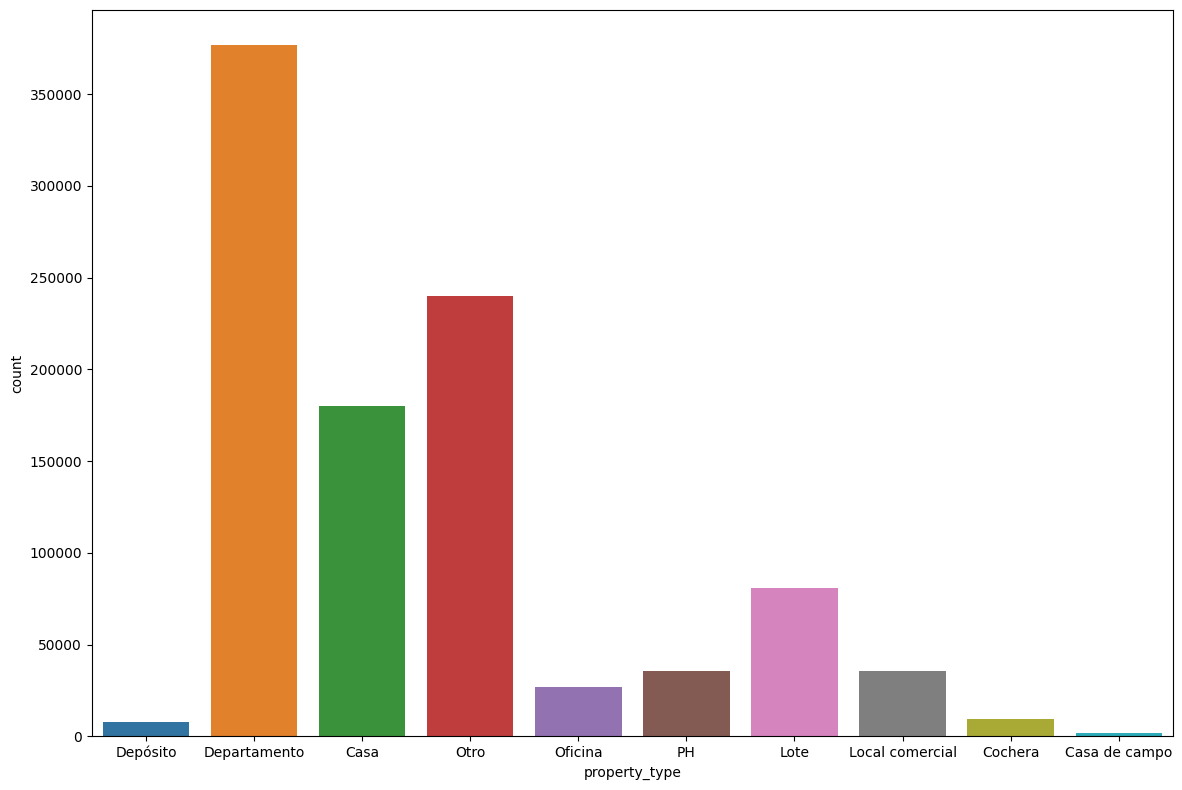

In [69]:
sns.countplot(x = "property_type", data = df_train)
plt.tight_layout()
plt.show(block=False)

In [70]:
df_train = df_train.drop_duplicates(keep="last")

In [71]:
df_train = df_train.reset_index(drop=False)

In [72]:
to_drop = ['surface_total','surface_covered','rooms','price']
df_train = df_train.dropna(subset = to_drop, axis = 0)
df_train.head(2)

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
27,461858,Propiedad,2019-07-04,2019-07-07,2019-07-04,-58.430523,-34.587761,Argentina,Capital Federal,Palermo,None,None,NaN,1.0,NaN,1.0,35.0,35.0,13000.0,ARS,None,Alquiler PH en Palermo Capital Federal Santa R...,"PH en Alquiler, Amplio Monoambiente tipo PH en...",PH,Alquiler
63,461862,Propiedad,2019-07-04,2019-07-11,2019-07-04,-58.516410,-34.591034,Argentina,Capital Federal,Villa Devoto,None,None,NaN,2.0,NaN,1.0,50.0,450.0,13000.0,ARS,Mensual,PH - Villa Devoto,"Excelente duplex recién pintado , en muy buen...",PH,Alquiler


In [73]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268947 entries, 27 to 967850
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               268947 non-null  int64         
 1   ad_type          268947 non-null  object        
 2   start_date       268947 non-null  datetime64[ns]
 3   end_date         228957 non-null  datetime64[ns]
 4   created_on       268947 non-null  datetime64[ns]
 5   lat              244345 non-null  float64       
 6   lon              244345 non-null  float64       
 7   l1               268947 non-null  object        
 8   l2               268947 non-null  object        
 9   l3               263046 non-null  object        
 10  l4               76321 non-null   object        
 11  l5               1733 non-null    object        
 12  l6               0 non-null       float64       
 13  rooms            268947 non-null  float64       
 14  bedrooms         167874 

In [74]:
df_train.isnull().sum().rename_axis("Feature", axis=0).sort_values(ascending=False).to_frame("Missing Values") / len(df_train)

,Missing Values
Feature,
l6,1.000000
l5,0.993556
l4,0.716223
price_period,0.571403
bedrooms,0.375810
end_date,0.148691
lat,0.091475
lon,0.091475
bathrooms,0.027362


In [75]:
wrong_surface_rows = df_train[df_train['surface_total'] < df_train['surface_covered']]
len(wrong_surface_rows)

3229

In [79]:
df_train.loc[wrong_surface_rows.index, 'surface_total']

63         50.0
1489       90.0
1890      100.0
2206      238.0
2447       95.0
          ...  
966420     71.0
966438     49.0
966636     36.0
966883     58.0
967771    110.0
Name: surface_total, Length: 3229, dtype: float64

In [80]:
df_train.loc[pd.Series(wrong_surface_rows.index), 'surface_total'] = wrong_surface_rows.surface_covered
df_train.loc[pd.Series(wrong_surface_rows.index), 'surface_covered'] = wrong_surface_rows.surface_total

In [ ]:
conteo_puntos = df_filtered.groupby(['lat', 'lon']).size()
conteo_puntos[conteo_puntos > 1].sort_values(ascending=False).head(10)

In [81]:
conteo_puntos = df_train.groupby(['lat', 'lon']).size()
conteo_puntos[conteo_puntos > 1].sort_values(ascending=False).head(10)

lat         lon       
-58.455819  -34.579326    965
-58.421008  -34.608248    618
-58.440873  -34.597760    313
-58.420728  -34.589767    305
-58.430038  -34.598219    285
-58.442232  -34.593371    277
-58.420122  -34.588007    263
-58.417970  -34.603810    262
-58.438364  -34.642835    235
-58.448509  -34.598529    235
dtype: int64

# Limpieza y transformación de datos (magia parte 2 -- MD)

In [ ]:
# Selección de datos. Solo a fines demostrativos. Cambiar!
df_train = df_train.loc[(df_train.l2 == "Córdoba") & (df_train.operation_type == 'Venta') & (df_train.property_type == 'Casa')]
df_train.shape

(11100, 24)

In [ ]:
## esto tiene que hacerse antes y mejor
df_train.fillna(0, inplace=True, downcast= "infer")
df_test.fillna(0, inplace=True, downcast= "infer") 

In [ ]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos

    return (X_train, y_train, X_test)

# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [ ]:
# Datos para probar
df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

X = df_train[df_train.columns.drop('price')]
y = df_train['price']

In [ ]:
# Creamos el modelo
reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

# Partimos en entrenamiento+prueba y validación
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

scores_train = []
scores_test = []
# Validación cruzada, 10 folds, shuffle antes
kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
    X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

    X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

    # Entrenamos el modelo
    reg.fit(X_train, y_train)

    # Predecimos en train
    y_pred = reg.predict(X_train)

    # Medimos la performance de la predicción en test
    score_train = sk.metrics.mean_squared_error(y_train, y_pred)
    scores_train.append(score_train)

    # Predecimos en test
    y_pred = reg.predict(X_test)    

    # Medimos la performance de la predicción en test
    score_test = sk.metrics.mean_squared_error(y_test, y_pred)
    scores_test.append(score_test)
    
    print(f"{fold=}, {score_train=} {score_test=}")
    

print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

fold=0, score_train=656619551068.9652 score_test=723458864862.029
fold=1, score_train=705282813566.9788 score_test=407119553109.7009
fold=2, score_train=643023999928.6862 score_test=994184852024.9316
fold=3, score_train=665345121159.0591 score_test=1046921316854.067
fold=4, score_train=676453853218.504 score_test=1078025506441.9459
fold=5, score_train=711032810564.2731 score_test=369502566520.8514
fold=6, score_train=691216432021.5255 score_test=459109057184.1242
fold=7, score_train=692006631232.408 score_test=611882224415.666
fold=8, score_train=625610260389.6654 score_test=1308765643364.4905
fold=9, score_train=633034962823.5765 score_test=1188451212540.4434
Train scores mean=669962643597.3641, std=30129180014.069405
Test scores mean=818742079731.825, std=346303785730.9732


# Predicción para kaggle


In [ ]:
## Datos a predecir 
X = df_train[df_train.columns.drop('price')]
y = df_train['price']
X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

# Entrenamos el modelo con todos los datos
reg.fit(X, y)

# Predecimos
df_test['price'] = reg.predict(X_prueba)

# Grabamos
df_test['price'].to_csv('solucion.csv', index=True)

In [ ]:
pd.DataFrame(zip(df_train.columns.drop('price'), reg.feature_importances_), columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False)

,column,feature_importance
1,lon,0.284658
0,lat,0.212267
4,rooms,0.141806
8,surface_covered,0.125101
5,bedrooms,0.095744
7,surface_total,0.073814
6,bathrooms,0.066611
2,l5,0.000000
3,l6,0.000000
